# LDA Topic Modelling for Amazon Electronics Reviews

Topic modelling is a method of finding a topic from the collection of documents that best represents the information in those documents. It enables the discovery of hidden patterns, to annotate documnets and to summarise documents.

Topic modelling will be conducted on the Amazon book review dataset, that spans the timeframe May 1996 - July 2014, found here: http://jmcauley.ucsd.edu/data/amazon/

This dataset contains review text, ratings and helpfulness votes. For purposes here, only the reviews will be used.

The text data will be preprocessed and then used to build the LDA model.

In [1]:
import pandas as pd
import numpy as np
import gzip

import string
import re
from pprint import pprint

# NLTK 
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatisation
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## 1. Extract and explore data

In [2]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def get_df(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [3]:
df = get_df('data/reviews_Electronics_5.json.gz')
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3.0,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2.0,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1.0,"Major issues, only excuses for support",1317254400,"09 29, 2011"


In [4]:
df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689188 entries, 0 to 1689187
Data columns (total 9 columns):
reviewerID        1689188 non-null object
asin              1689188 non-null object
reviewerName      1664458 non-null object
helpful           1689188 non-null object
reviewText        1689188 non-null object
overall           1689188 non-null float64
summary           1689188 non-null object
unixReviewTime    1689188 non-null int64
reviewTime        1689188 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 128.9+ MB


In [6]:
df['reviewText'][0]

'We got this GPS for my husband who is an (OTR) over the road trucker.  Very Impressed with the shipping time, it arrived a few days earlier than expected...  within a week of use however it started freezing up... could of just been a glitch in that unit.  Worked great when it worked!  Will work great for the normal person as well but does have the "trucker" option. (the big truck routes - tells you when a scale is coming up ect...)  Love the bigger screen, the ease of use, the ease of putting addresses into memory.  Nothing really bad to say about the unit with the exception of it freezing which is probably one in a million and that\'s just my luck.  I contacted the seller and within minutes of my email I received a email back with instructions for an exchange! VERY impressed all the way around!'

In [7]:
data = df['reviewText'].values.tolist()

In [8]:
print(data[:1])

['We got this GPS for my husband who is an (OTR) over the road trucker.  Very Impressed with the shipping time, it arrived a few days earlier than expected...  within a week of use however it started freezing up... could of just been a glitch in that unit.  Worked great when it worked!  Will work great for the normal person as well but does have the "trucker" option. (the big truck routes - tells you when a scale is coming up ect...)  Love the bigger screen, the ease of use, the ease of putting addresses into memory.  Nothing really bad to say about the unit with the exception of it freezing which is probably one in a million and that\'s just my luck.  I contacted the seller and within minutes of my email I received a email back with instructions for an exchange! VERY impressed all the way around!']


## 2. Data Preprocessing

The corpus - text reviews - need to be preprocessed. The approach here will involve:
+ Tokenizing: converting reviews to their atomic elements
+ Stopping: removing meaningless words
+ Lemmatise: merging words that are equivalent in meaning

### Tokenization

In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['we', 'got', 'this', 'gps', 'for', 'my', 'husband', 'who', 'is', 'an', 'otr', 'over', 'the', 'road', 'trucker', 'very', 'impressed', 'with', 'the', 'shipping', 'time', 'it', 'arrived', 'few', 'days', 'earlier', 'than', 'expected', 'within', 'week', 'of', 'use', 'however', 'it', 'started', 'freezing', 'up', 'could', 'of', 'just', 'been', 'glitch', 'in', 'that', 'unit', 'worked', 'great', 'when', 'it', 'worked', 'will', 'work', 'great', 'for', 'the', 'normal', 'person', 'as', 'well', 'but', 'does', 'have', 'the', 'trucker', 'option', 'the', 'big', 'truck', 'routes', 'tells', 'you', 'when', 'scale', 'is', 'coming', 'up', 'ect', 'love', 'the', 'bigger', 'screen', 'the', 'ease', 'of', 'use', 'the', 'ease', 'of', 'putting', 'addresses', 'into', 'memory', 'nothing', 'really', 'bad', 'to', 'say', 'about', 'the', 'unit', 'with', 'the', 'exception', 'of', 'it', 'freezing', 'which', 'is', 'probably', 'one', 'in', 'million', 'and', 'that', 'just', 'my', 'luck', 'contacted', 'the', 'seller', 'and

### Bigrams & Trigrams

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

In [12]:
#build bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

#faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# view trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['we', 'got', 'this', 'gps', 'for', 'my', 'husband', 'who', 'is', 'an', 'otr', 'over', 'the', 'road', 'trucker', 'very', 'impressed', 'with', 'the', 'shipping', 'time', 'it', 'arrived', 'few', 'days', 'earlier', 'than', 'expected', 'within', 'week', 'of', 'use', 'however', 'it', 'started', 'freezing', 'up', 'could', 'of', 'just', 'been', 'glitch', 'in', 'that', 'unit', 'worked', 'great', 'when', 'it', 'worked', 'will', 'work', 'great', 'for', 'the', 'normal', 'person', 'as', 'well', 'but', 'does', 'have', 'the', 'trucker', 'option', 'the', 'big', 'truck', 'routes', 'tells', 'you', 'when', 'scale', 'is', 'coming', 'up', 'ect', 'love', 'the', 'bigger', 'screen', 'the', 'ease', 'of', 'use', 'the', 'ease', 'of', 'putting', 'addresses', 'into', 'memory', 'nothing', 'really', 'bad', 'to', 'say', 'about', 'the', 'unit', 'with', 'the', 'exception', 'of', 'it', 'freezing', 'which', 'is', 'probably', 'one', 'in', 'million', 'and', 'that', 'just', 'my', 'luck', 'contacted', 'the', 'seller', 'and'

### Remove Stop Words, Make Bigrams and Lemmatise

In [13]:
#define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
#remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [15]:
#form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [16]:
#initialise spacy model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

#lemmatisation keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['get', 'trucker', 'impress', 'shipping', 'time', 'arrive', 'day', 'earlier', 'expect', 'week', 'use', 'however', 'start', 'freeze', 'could', 'glitch', 'unit', 'work', 'great', 'worked', 'work', 'great', 'normal', 'person', 'trucker', 'option', 'big', 'truck', 'route', 'tell', 'scale', 'come', 'ect', 'love', 'big', 'screen', 'ease', 'use', 'ease', 'putting', 'address', 'memory', 'really', 'bad', 'say', 'unit', 'exception', 'freeze', 'probably', 'luck', 'contact', 'seller', 'minute', 'email', 'receive', 'email', 'instruction', 'exchange', 'impress', 'way', 'around']]


### Create dictionary and corpus required for topic modelling

Here tokenised reviews are transformed into an id-term dictionary.

Gensim's Dictionary method encapsulates the mapping between normalised words and their integer ids. A term will have an id of some number and in the subsequent bag of words step, that id will have a count associated with it.

In [17]:
#create dictionary
id2word = corpora.Dictionary(data_lemmatized)

In [18]:
#create corpus
texts = data_lemmatized

In [19]:
#term document frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [20]:
#view sample
print('Corpus sample: ', corpus[:1])

#to see what word a given id corresponds to, pass id as a key to the dictionary
print('ID 0 corresponds to the word: ', id2word[0])

# Human readable format of corpus (term-frequency)
print('Human readable format of corpus (term-frequency): ', [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]])

Corpus sample:  [[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 2), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 2), (46, 2), (47, 1), (48, 1), (49, 2), (50, 1)]]
ID 0 corresponds to the word:  address
Human readable format of corpus (term-frequency):  [[('address', 1), ('around', 1), ('arrive', 1), ('bad', 1), ('big', 2), ('come', 1), ('contact', 1), ('could', 1), ('day', 1), ('earlier', 1), ('ease', 2), ('ect', 1), ('email', 2), ('exception', 1), ('exchange', 1), ('expect', 1), ('freeze', 2), ('get', 1), ('glitch', 1), ('great', 2), ('however', 1), ('impress', 2), ('instruction', 1), ('love', 1), ('luck', 1), ('memory', 1), ('minute', 1), ('normal', 1), ('option', 1), ('person', 1), (

## 3. Building the topic model

LDA (Latent Dirichlet Allocation) will be used here. It considers each document as a collection of topics in a certain proportion, and each topic as a collection of keywords in a certain proportion.

A topic is considered here as just a collection of dominant keywords that are typical representatives. Just by looking at the keywords, you can identify what the topic is all about. Key factors to obtaining good segregation topics include:
+ quality of text processing
+ variety of topics the text talks about
+ choice of topic modelling algorithm
+  number of topics fed to the algorithm
+ algorithms tuning parameters

For now, the model will be built with 20 topics, where each topic will be a combination of keywords and each keyword contributes a certain weightage to the topic.

### 3.1 Gensim's inbuilt version of the LDA algorithm

First, a base model will be built using default values to generate a base level cohereence score.

In [21]:
#build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [22]:
#print keyword in topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.117*"record" + 0.054*"ready" + 0.053*"wife" + 0.046*"magnet" + '
  '0.037*"degree" + 0.036*"shape" + 0.033*"dock" + 0.032*"complain" + '
  '0.029*"safe" + 0.024*"door"'),
 (1,
  '0.125*"tv" + 0.057*"room" + 0.041*"definitely" + 0.040*"front" + '
  '0.034*"protection" + 0.030*"channel" + 0.030*"attach" + 0.028*"similar" + '
  '0.025*"super" + 0.023*"bar"'),
 (2,
  '0.091*"work" + 0.062*"great" + 0.059*"good" + 0.039*"need" + '
  '0.039*"quality" + 0.038*"product" + 0.036*"easy" + 0.035*"price" + '
  '0.035*"cable" + 0.034*"buy"'),
 (3,
  '0.109*"support" + 0.094*"open" + 0.078*"call" + 0.076*"image" + '
  '0.057*"inch" + 0.046*"strap" + 0.029*"hit" + 0.026*"plenty" + 0.021*"tight" '
  '+ 0.021*"link"'),
 (4,
  '0.065*"charge" + 0.064*"camera" + 0.054*"battery" + 0.039*"light" + '
  '0.026*"provide" + 0.024*"picture" + 0.021*"charger" + 0.020*"take" + '
  '0.019*"hand" + 0.019*"mode"'),
 (5,
  '0.087*"sound" + 0.058*"speaker" + 0.036*"headphone" + 0.034*"music" + '
  '0.025*"au

An interpretation of the above is, for example, topic 0 is represented as '0.117*"record" + 0.054*"ready" + 0.053*"wife" + 0.046*"magnet" + ' '0.037*"degree" + 0.036*"shape" + 0.033*"dock" + 0.032*"complain" + ' '0.029*"safe" + 0.024*"door".
  
This means that the top 10 keywords that contribute to this topic are: record, ready, wife, magnet, degree, shape, dock, complain, safe and door. The numerical values are the weights of the keyword, which reflects how important a keyword is to that topic.

Looking at keywords, topics can be inferred.

#### Model Perplexity and Coherence Score

These are measures that judge how good a given topic model is.

In [23]:
#compute perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

#compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.6451873704818825

Coherence Score:  0.375982163319497


#### Visualise topics-keywords

In [24]:
# visualise topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.280816 -0.033874       1        1  30.267399
9      0.245299 -0.238085       2        1  26.100817
2      0.012407 -0.224270       3        1  11.849213
7      0.023246  0.172190       4        1   9.067723
4      0.072091  0.237652       5        1   6.670008
5      0.072571  0.234015       6        1   5.709555
8     -0.053025  0.002705       7        1   5.566611
1     -0.213676 -0.052591       8        1   2.375348
3     -0.218691 -0.051085       9        1   1.582495
0     -0.221038 -0.046657      10        1   0.810831, topic_info=     Category           Freq      Term          Total  loglift  logprob
49    Default  877352.000000      work  877352.000000  30.0000  30.0000
974   Default  546754.000000      case  546754.000000  29.0000  29.0000
19    Default  599065.000000     great  599065.000000  28.0000  28.0000
205   Default  710053.000000      good  710053.000000  27.0000  27.0000
1504  Default  405034.000000     sound  405034.000000  26.0000  26.0000
...       ...            ...       ...            ...      ...      ...
1866  Topic10    6206.013672   backlit    6206.580566   4.8148  -4.6716
2507  Topic10    5685.168457     punch    5685.735352   4.8148  -4.7593
3027  Topic10    5559.266602  playlist    5559.833496   4.8148  -4.7817
5111  Topic10    5072.710449       wet    5073.277344   4.8148  -4.8732
3311  Topic10    4997.942871  absolute    4998.509766   4.8148  -4.8881

[396 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
414       1  0.981428        able
414       5  0.018569        able
3311     10  0.999898    absolute
384       2  0.999995    actually
756       9  0.999968  affordable
...     ...       ...         ...
309       1  0.071112       would
309       2  0.600357       would
309       3  0.328531       would
382       1  0.999993        year
2132      6  0.999939     youtube

[423 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 10, 3, 8, 5, 6, 9, 2, 4, 1])

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent the topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant. A model with too many topics, will have many overlaps, small-sized bubbles, clustered in one region of the chart. This plot shows a large number of small bubbles clustered on the lower left-side quadrant, and also some clustering at the top - this indicates that there are too many topics.

When the cursor is moved over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

#### Hyperparameter tuning

With the baseline coherence score, a series of sensitivity tests can now be performed to help determine the following hyperparameters that optimise the coherence score:
1. Number of topics (k)
2. Dirichlet hyperparameter alpha: document-topic density
3. Dirichlet hyperparameter beta: word-topic density

The tests will be conducted in sequence, one parameter at a time, keeping others constant.

In [25]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
#######################################################################
#   works, but stopped as would have taken over 100 days to complete  #
#                  with existing computing power                      #
#######################################################################

import tqdm

grid = {}
grid['Validation_Set'] = {} 

# topics range
min_topics = 2
max_topics = 15
step_size = 1
topics_range = range(min_topics, max_topics, step_size) 

#alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric') 

#beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        
        # iterate through number of topics
        for k in topics_range:
            
            # iterate through alpha values
            for a in alpha:
                
                # iterate through beta values
                for b in beta:
                    
                    # get coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    #save model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index = False)
    
    pbar.close()

#### Final model

As hyperparameters could not be tuned due to computing power limitations, 'optimal' parameters will be selected arbitrarily. For purposes here, number of topics will be based on the plot above, which shows overlap. So number of topics will be selected based on the number of distinct bubble locations.

In [27]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=7, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha=0.01,
                                       eta=0.05,
                                       per_word_topics=True)

In [28]:
import pickle 

#visualise topics
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model,
                                          corpus,
                                          id2word)

LDAvis_prepared

/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.016794 -0.081916       1        1  19.164663
6      0.065766  0.129229       2        1  17.404028
4     -0.067523 -0.117286       3        1  16.532806
5      0.022875 -0.048178       4        1  12.790309
0      0.094261 -0.034512       5        1  12.115993
1      0.071285  0.074154       6        1  11.147864
3     -0.203460  0.078509       7        1  10.844331, topic_info=     Category           Freq    Term        Total  loglift  logprob
1567  Default  475887.000000  camera  475887.0000  30.0000  30.0000
1504  Default  450290.000000   sound  450290.0000  29.0000  29.0000
974   Default  557780.000000    case  557780.0000  28.0000  28.0000
408   Default  336484.000000   cable  336484.0000  27.0000  27.0000
407   Default  285805.000000      tv  285805.0000  26.0000  26.0000
...       ...            ...     ...          ...      ...      ...
305    Topic7   65467.640625    well  607575.3750  -0.0064  -4.9083
17     Topic7   59403.175781     get  736531.8750  -0.2961  -5.0055
309    Topic7   54936.527344   would  604405.8125  -0.1765  -5.0837
205    Topic7   49392.789062    good  748918.7500  -0.4973  -5.1901
152    Topic7   48225.691406    also  429874.1250   0.0339  -5.2140

[568 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4882      6  0.999792  acoustic
454       1  0.095595   adapter
454       3  0.116275   adapter
454       5  0.019710   adapter
454       7  0.768423   adapter
...     ...       ...       ...
382       4  0.056217      year
382       5  0.097859      year
382       6  0.055463      year
3096      4  0.012890      zoom
3096      5  0.987104      zoom

[1264 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 5, 6, 1, 2, 4])

In [29]:
#compute perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

#compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.507900151947174

Coherence Score:  0.4260260166011451


Changing these parameters has resulted in an improvement in coherence from 0.376 to 0.426.

### 3.2 Mallet's LDA model

Mallet's version is said to give better quality of topics. To use this version, for which Gensim provides a wrapper to implement within Gensim, the zipfile needs to be downloaded.

The MALLET topic model package includes an extremely fast and highly scalable implementation of Gibbs sampling, efficient methods for document-topic hyperparameter optimisation, and tools for inferring topics for new documents given trained models.

In [74]:
import os
from gensim.models.wrappers import LdaMallet

# downloaded file from http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
os.environ['MALLET_HOME'] = 'C:/Users/charlottefettes/mallet-2.0.8'

mallet_path = 'mallet-2.0.8/bin/mallet'

In [55]:
lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path,
                                              corpus=corpus,
                                              num_topics=10,
                                              id2word=id2word,
                                              iterations=1000)

#### Show topics

In [56]:
pprint(lda_mallet.show_topics(formatted = False))

[(0,
  [('cable', 0.054998233263750765),
   ('card', 0.041702794371198275),
   ('make', 0.022446034691912475),
   ('run', 0.01601674506628089),
   ('fan', 0.012883366793743025),
   ('build', 0.012536341199025),
   ('memory', 0.012216598536969372),
   ('end', 0.01118184340794439),
   ('cool', 0.010343725025303256),
   ('mount', 0.009991209572183652)]),
 (1,
  [('time', 0.022739900060011933),
   ('review', 0.021684483333775647),
   ('unit', 0.020729086497371946),
   ('problem', 0.020455993674063002),
   ('give', 0.014996848160675603),
   ('day', 0.014585211381550054),
   ('update', 0.013929160806014777),
   ('back', 0.013074782631524728),
   ('year', 0.013003299086865492),
   ('return', 0.01221826423114668)]),
 (2,
  [('sound', 0.06335003600477515),
   ('speaker', 0.031460348304012314),
   ('good', 0.031029963559165357),
   ('quality', 0.028446161735660138),
   ('headphone', 0.022244559485832097),
   ('music', 0.020313054874502974),
   ('ear', 0.015538352776310143),
   ('high', 0.0148872

#### Coherence score

In [57]:
#coherence score
coherence_model_ldamallet = CoherenceModel(model=lda_mallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5026676509592649


#### Hyperparameter tuning

For this version, only the number of topics parameter will be optimised.

In [58]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [59]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=2,
                                                        limit=20,
                                                        step=3)

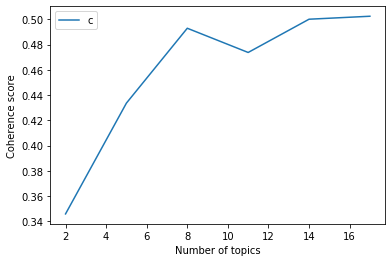

In [60]:
#plot graph
limit=20; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [61]:
# coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3458
Num Topics = 5  has Coherence Value of 0.4336
Num Topics = 8  has Coherence Value of 0.4929
Num Topics = 11  has Coherence Value of 0.4737
Num Topics = 14  has Coherence Value of 0.5
Num Topics = 17  has Coherence Value of 0.5024


In [71]:
# select model (looks as though should have included higher number of topics but highest here is 17) and print topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.069*"card" + 0.033*"run" + 0.022*"memory" + 0.021*"fan" + 0.017*"cool" + '
  '0.016*"game" + 0.016*"performance" + 0.015*"fast" + 0.014*"build" + '
  '0.013*"high"'),
 (1,
  '0.091*"cable" + 0.050*"product" + 0.034*"order" + 0.024*"purchase" + '
  '0.023*"return" + 0.022*"item" + 0.020*"receive" + 0.018*"send" + '
  '0.016*"replacement" + 0.016*"day"'),
 (2,
  '0.110*"case" + 0.042*"screen" + 0.038*"cover" + 0.034*"ipad" + '
  '0.029*"tablet" + 0.022*"fit" + 0.016*"protect" + 0.016*"hold" + '
  '0.015*"stand" + 0.014*"protector"'),
 (3,
  '0.065*"tv" + 0.031*"set" + 0.025*"monitor" + 0.023*"picture" + 0.020*"room" '
  '+ 0.017*"hdmi" + 0.017*"screen" + 0.016*"color" + 0.015*"watch" + '
  '0.014*"channel"'),
 (4,
  '0.037*"video" + 0.034*"play" + 0.033*"player" + 0.029*"remote" + '
  '0.017*"feature" + 0.017*"device" + 0.013*"record" + 0.012*"app" + '
  '0.012*"control" + 0.012*"movie"'),
 (5,
  '0.045*"keyboard" + 0.033*"button" + 0.031*"mouse" + 0.023*"feel" + '
  '0.022*"ke

#### Visualising the optimal LDA Mallet model

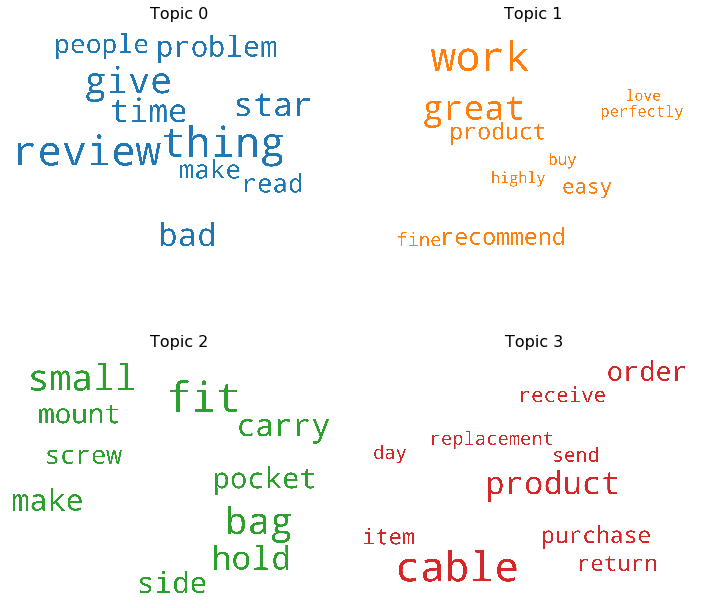

In [72]:
# Wordcloud of top n words in each topic - will visualise only the first 4 topics
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
topics = optimal_model.show_topics(formatted=False)
fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#### Finding the dominant topic in each sentence

This will be the topic number that has the highest percentage contribution in that text.

In [ ]:
#function to aggregate information on topic number of % contribution

def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    sent_topics_df = pd.DataFrame()

    #get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        #get dominant topic, % contribution and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  #dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    #add original text to end of output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

#format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_Number', 'Dominant_Topic', 'Topic_Percentage_Contribution', 'Keywords', 'Text']

#show
df_dominant_topic.head(10)

In [ ]:
#print table
df_dominant_topic.shape

#### Find the most representative document for each topic

By looking beyond topic keywords to the text that has contributed to a topic the most can give further insight into, and infer, that topic by reading that text.

In [ ]:
#group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

#reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

#format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

#show
sent_topics_sorteddf_mallet.head()

#### Topic distribution across documents

This enables an understanding on volumne and distribution of topics so as to judge how widely it was discussed.

In [ ]:
#number of documents for each topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

#% documents for each topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# topic number and keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# concatenate column-wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# change column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# show
df_dominant_topics.head()